In [58]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/PLDAC/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/PLDAC


In [111]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re

In [ ]:
!pip install bert_score

Read CQR data

In [230]:
canard_types = {
	0: "all queries, no answers",
	1: "all queries, last 1 answers",
	2: "all queries, last 2 answers",
	3: "all queries, last 3 answer",
	4: "all queries, all answers"
}

def read_canard(type):
	canard_path = "./data/canard"
	TYPES = ["_all_0","_all_1","_all_2","_all_3","_all_all"]
	df = pd.concat([\
		pd.read_csv(f"{canard_path}/train{TYPES[type]}.csv"),\
		pd.read_csv(f"{canard_path}/dev{TYPES[type]}.csv"),\
		pd.read_csv(f"{canard_path}/test{TYPES[type]}.csv")\
		], ignore_index=True)
	train = df[:-750]
	val = df[-750:]
	return train, val # 40000 examples, in which 750 for val

trec_versions = {
	1: "raw queries",
	2: "rewritten queries",
	3: "full history",
	4: "full history, 2 first sentences",

	5: "overlap last answer",
	6: "overlap last 2 answers",
	7: "overlap last 3 answers",
	8: "overlap all answers",

	9: "maxsim last answer",
	10: "maxsim last 2 answers",
	11: "maxsim last 3 answers",
	12: "maxsim all answers",

	13: "bert sim last answer",
	14: "bert sim last 2 answers",
	15: "bert sim last 3 answers",
	16: "bert sim all answers"
}

def read_trec(year,version):
	assert year==2020 or year==2021
	assert version in range(1,17)
	trec_path = "./data/treccast"
	test = pd.read_csv(f"{trec_path}/{year}/trec{year}_{version}.csv").reset_index()
	return test # about 250 examples

def createCQRdata(canard_type,trec_version):
	# 750 first examples are from CANARD, the rest from TREC
	train, val = read_canard(canard_type)
	val = pd.concat([\
		val,\
		read_trec(2020,trec_version),\
		read_trec(2021,trec_version)\
		] ,ignore_index=True)
	return train[["Source","Target"]], val[["Source","Target"]]

def get_val_immediate_evaluation(canard_type, trec_type):
    _, val = createCQRdata(canard_type, trec_type)
    val["Raw"] = val["Source"].apply(lambda context: context[7:].split("||||",2)[0])
    return val

def get_val_IR_evaluation(filename,get_target=False):
	# 750 first examples are from CANARD, the rest from TREC
	predictions = pd.read_csv(filename,sep='\t')[750:].reset_index()
	if get_target:
		column = "Target"
	else:
		column = "Prediction"
	predictions = predictions[column].apply(lambda x: re.sub("[^A-Za-z0-9 ]+"," ",x.rstrip()))
	predictions = predictions.to_frame(name="query")
	predictions['qid'] = predictions.index
	predictions['qid'] = predictions['qid'].astype(str)
	return predictions

# Qualitative evaluation

In [5]:
def cqr_df(filename,canard_type, trec_type):
    val = get_val_immediate_evaluation(canard_type, trec_type)
    predictions = pd.read_csv(filename,sep='\t')
    val["Prediction"] = predictions["Prediction"]
    return val

In [7]:
cqr_1_5 = cqr_df("/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_1_5/predictions_4.csv",1,5)
cqr_1_5.head()

,Source,Target,Raw,Prediction
0,Query: Was Daniel Pipes a problem at college? ...,Was Daniel Pipes a problem at college?,Was Daniel Pipes a problem at college?,Was Daniel Pipes a problem at college?
1,Query: Was Daniel Pipes involved with any prot...,Was Daniel Pipes involved with any protests at...,Was Daniel Pipes involved with any protests at...,Was Daniel Pipes involved with any protests at...
2,Query: What did Daniel Pipes do after teaching...,What did Daniel Pipes do after teaching college?,What did Daniel Pipes do after teaching college?,What did Daniel Pipes do after teaching college?
3,Query: What are his dealings with Campus Watch...,What are Daniel Pipes' dealings with Campus Wa...,What are his dealings with Campus Watch?,What are Daniel Pipes' dealings with Campus Wa...
4,Query: What did Daniel Pipes have to do with t...,What did Daniel Pipes have to do with the Lega...,What did Daniel Pipes have to do with the Lega...,What did Daniel Pipes have to do with the Lega...


# Bertscore evaluation

In [ ]:
from bert_score import score

val = get_val_immediate_evaluation(0,1)[["Raw","Target"]]
runs = ["0_1","1_5","1_9","2_10","2_14","3_11","3_15"]

def assess_bertscore(runs=runs,epochs=5,n=val.shape[0]):
    cache = f"/content/gdrive/MyDrive/PLDAC/models/CQR/bertscore_{n}.npz"
    if os.path.isfile(cache):
        data = np.load(cache)
        P = data['P']
        R = data['R']
        F1 = data['F1']
    else:
        P = np.zeros((len(runs),epochs,n))
        R = np.zeros((len(runs),epochs,n))
        F1 = np.zeros((len(runs),epochs,n))
    for i in range(len(runs)):

        run = runs[i]
        print(f"Run {run}")
        dir = f"/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_{run}"

        for epoch in range(epochs):

            print(f"Epoch {epoch}")
            filename = f"{dir}/predictions_{epoch+1}.csv"

            if P[i,epoch,-1] != 0 and R[i,epoch,-1] != 0 and F1[i,epoch,-1] != 0:
                continue

            df = pd.read_csv(f"{dir}/predictions_{epoch+1}.csv",sep='\t')
            preds = df["Prediction"].tolist()
            refs = df["Target"].tolist()
            p, r, f1 = score(preds,refs,lang='en',verbose=True)
            P[i,epoch,:] = p
            R[i,epoch,:] = r
            F1[i,epoch,:] = f1
            np.savez(cache,P=P,R=R,F1=F1)
            
    return P, R, F1

In [ ]:
P, R, F1 = assess_bertscore()

In [177]:
def read_cache(cache="/content/gdrive/MyDrive/PLDAC/models/CQR/bertscore_1205.npz"):
    data = np.load(cache)
    P = data['P']
    R = data['R']
    F1 = data['F1']
    return P,R,F1

In [178]:
P,R,F1 = read_cache()

In [ ]:
Praw, Rraw, F1raw = score(val["Raw"].tolist(),val["Target"].tolist(),lang='en',verbose=True)

In [180]:
def aggregate_assessment(P,R,F1):
    data = np.load("/content/gdrive/MyDrive/PLDAC/models/CQR/bertscore_1205_raw.npz")
    Praw, Rraw, F1raw = data["P"],data["R"],data["F1"]
    Prawmu,Rrawmu,F1rawmu = Praw.mean(),Rraw.mean(),F1raw.mean()
    Prawsig,Rrawsig,F1rawsig = Praw.std(),Rraw.std(),F1raw.std()
    Pmu, Rmu, F1mu = np.mean(P,axis=2), np.mean(R,axis=2), np.mean(F1,axis=2)
    Psig, Rsig, F1sig = np.std(P,axis=2), np.std(R,axis=2), np.std(F1,axis=2)
    diffP, diffR, diffF1 = Pmu-Prawmu, Rmu-Rrawmu, F1mu-F1rawmu
    plt.figure()
    #print(diffP)
    #print(Prawsig)
    plt.imshow(diffP)
    plt.figure()
    #print(diffR)
    #print(Rrawsig)
    plt.imshow(diffR)
    plt.figure()
    print(F1mu)
    print(F1rawmu)
    print(F1rawsig)
    plt.imshow(diffF1)
    data = P, R, F1, Pmu, Rmu, F1mu, Psig, Rsig, F1sig,Prawmu,Rrawmu,F1rawmu,Prawsig,Rrawsig,F1rawsig
    return data

[[0.93368015 0.94145263 0.93467813 0.93763451 0.93153452]
 [0.93459791 0.94938529 0.9570392  0.95708327 0.95626924]
 [0.93334672 0.9483571  0.95683238 0.95693477 0.95614658]
 [0.94895482 0.94593532 0.94688171 0.94754708 0.94318503]
 [0.95004905 0.94622085 0.94730677 0.94777506 0.94609658]
 [0.94144739 0.94855349 0.93820359 0.94717767 0.93884857]
 [0.94188615 0.94905098 0.93836539 0.94772138 0.93932907]]
0.9476779
0.033523306


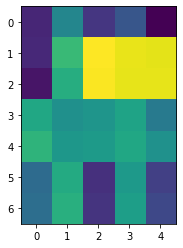

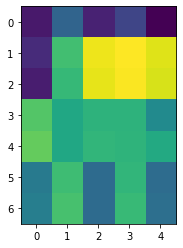

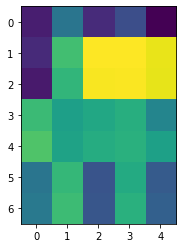

In [181]:
data = aggregate_assessment(P,R,F1)

Apparently bert_score is not a good metric to measure information need, because it suggests that leaving the raw query as-is is almost as good as reformulations. Also, overlap extraction is not convincing in qualitative evaluation, yes performs best in bert score evaluation.

It suggests overfit at 5th epoch.

# Downstream Conversational IR Task

Corpus: MSMarco Passage



In [44]:
dataset = pt.get_dataset("irds:msmarco-passage")

Pipeline: BM25 DocT5Query >> MonoT5

In [ ]:
!pip install -q python-terrier
!pip install --upgrade git+https://github.com/terrierteam/pyterrier_t5.git

In [50]:
import pyterrier as pt
if not pt.started():
    pt.init()
from pyterrier_t5 import MonoT5ReRanker

In [51]:
bm25_terrier_stemmed_docT5query = pt.BatchRetrieve.from_dataset('msmarco_passage', 'terrier_stemmed_docT5query', wmodel='BM25')
monoT5 = MonoT5ReRanker()
#duoT5 = DuoT5ReRanker()

If Conversational IR data is limited to TREC CAsT data, then MSMarco passage can provide many good answers (up to 10). The same cannot be said for CANARD Conversational IR data, which is based on another corpus.

In [172]:
BM_CUTOFF = 50
TOP_K = 10
IR_pipeline = (bm25_terrier_stemmed_docT5query % BM_CUTOFF).compile() >> pt.text.get_text(dataset, "text") >> monoT5 % TOP_K

Applying 8 rules


Queries: TREC CAsT 2020 and 2021

    Conversation source: containing 455 TREC CAsT queries. I argue that the 750 val queries from CANARD do not serve well, as MSMarco may not contain documents answering to them.

In [231]:
val = get_val_IR_evaluation("/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_0_1/predictions_1.csv",get_target=True)

Qrels: unavailable. We use IR results of reference queries on MSMarco passage corpus as proxy qrels

In [232]:
mini_val = val[50:55]
mini_val

,query,qid
50,What type of orange tree has thorns,50
51,Where do orange trees originally come from,51
52,Tell me about the Hamlin orange variety,52
53,Why did the Hamlin orange replace the Parson B...,53
54,What are the different types of navel oranges,54


Select top TOP_K passages from reference query retrieval as positive qrels for downstream Conversational IR task

In [233]:
ref_IR_filename = "/content/gdrive/MyDrive/PLDAC/models/CQR/mini_ref.trec"
ref_res = IR_pipeline.transform(mini_val)
pt.io.write_results(ref_res, ref_IR_filename)

monoT5:   0%|          | 0/63 [00:00<?, ?batches/s]

Vincent, can you run this for me? It may take a few hours.

In [ ]:
ref_IR_filename = "/content/gdrive/MyDrive/PLDAC/models/CQR/ref.trec"
ref_res = IR_pipeline.transform(val)
pt.io.write_results(ref_res, ref_IR_filename)

monoT5:   0%|          | 0/5688 [00:00<?, ?batches/s]

Parse result file to qrel file

In [234]:
def parse_qrel(result_file,qrel_file):
    qrels = pd.read_csv(result_file,sep=' ',names=["qid","Q0","docno","rank","score","pyterrier"])
    qrels = qrels[["qid","docno"]]
    qrels["qid"] = qrels["qid"].apply(str)
    qrels["docno"] = qrels["docno"].apply(str)
    qrels["label"] = 1
    qrels.to_csv(qrel_file,sep=' ',header=False)
    return qrels

In [235]:
mini_qrels = parse_qrel("/content/gdrive/MyDrive/PLDAC/models/CQR/mini_ref.trec","/content/gdrive/MyDrive/PLDAC/models/CQR/mini_ref.qrel")

In [ ]:
qrels = parse_qrel("/content/gdrive/MyDrive/PLDAC/models/CQR/ref.trec","/content/gdrive/MyDrive/PLDAC/models/CQR/ref.qrel")

# Evaluation with downstream Conversational IR task

Reference performance

    Let's try with the mini dataset first

In [170]:
pt.Experiment(
    retr_systems=[IR_pipeline],
    topics=mini_val,
    qrels=mini_qrels,
    eval_metrics=["map", "recip_rank"],
    names=["Reference"]
)

monoT5:   0%|          | 0/63 [00:00<?, ?batches/s]

,name,map,recip_rank
0,"Compose(Compose(RankCutoff(BR(BM25), 50), <pyt...",1.0,1.0


    Of course it should give 1, the results from this IS the proxy qrels. Just a sanity check here.

In [ ]:
pt.Experiment(
    retr_systems=[IR_pipeline],
    topics=val,
    qrels=qrels,
    eval_metrics=["map", "recip_rank"]
)

    This will take a long time, but should give 1 too

We choose model checkpoints having good performance in both qualitative evaluation and Bertscore evaluation, because these metrics are likely able to suggest where overfit occurs.

In [157]:
def get_predictions(df):
    df = df["Prediction"].apply(lambda x: re.sub("[^A-Za-z0-9 ]+"," ",x.rstrip()))
    df = df.to_frame(name="query")
    df['qid'] = df.index.astype(str)
    return df

In [283]:
def aggregate_result(exprm,dir):
    name = exprm["name"][0]

    p5 = exprm[exprm["measure"] == "P_5"]["value"]
    p5_mean = p5.mean()
    p5_std = p5.std()

    map = exprm[exprm["measure"] == "map"]["value"]
    map_mean = map.mean()
    map_std = map.std()

    mrr = exprm[exprm["measure"] == "recip_rank"]["value"]
    mrr_mean = mrr.mean()
    mrr_std = mrr.std()

    ndcg = exprm[exprm["measure"] == "ndcg"]["value"]
    ndcg_mean = ndcg.mean()
    ndcg_std = ndcg.std()

    df = pd.DataFrame(data=[[name,p5_mean,p5_std,map_mean,map_std,mrr_mean,mrr_std,ndcg_mean,ndcg_std]],\
                      columns=[["name","P@5","P@5 std","map","map std","mrr","mrr std","ndcg","ndcg std"]])
    df.to_csv(f"{dir}/{name}.csv")
    return df

Run 0_1: T5 reformulation with only raw queries as input context

In [259]:
cqr_0_1_4 = get_val_IR_evaluation("/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_0_1/predictions_4.csv")
mini_cqr_0_1_4 = cqr_0_1_4[50:55]
mini_cqr_0_1_4.head()

,query,qid
50,Which type of orange tree has thorns,50
51,do the thorns originally come from,51
52,me about the Hamlin variety,52
53,Why did the Hamlin variety replace PB,53
54,are the different types of navels,54


In [ ]:
mini_res = IR_pipeline.transform(mini_cqr_0_1_4)
mini_res

In [286]:
mini_exp_0_1_4 = pt.Experiment(
    retr_systems=[IR_pipeline],
    topics=mini_cqr_0_1_4,
    qrels=mini_qrels,
    eval_metrics=["P_5", "map", "recip_rank", "ndcg", "mrt"],
    names=["mini_0_1_4"],
    save_dir="/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_0_1/",
    save_mode="overwrite",
    perquery=True
)
aggregate_result(mini_exp_0_1_4,"/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_0_1")

monoT5:   0%|          | 0/63 [00:00<?, ?batches/s]

,name,P@5,P@5 std,map,map std,mrr,mrr std,ndcg,ndcg std
0,mini_0_1_4,0.4,0.469042,0.311778,0.441866,0.486667,0.483965,0.373466,0.447197


    It's ok, the raw query is usually not that far off from the reference query

Vincent can you run these?

In [ ]:
exp_0_1_4 = pt.Experiment(
    retr_systems=[IR_pipeline],
    topics=cqr_0_1_4,
    qrels=qrels,
    eval_metrics=["P_5", "map", "recip_rank", "ndcg", "mrt"],
    names=["0_1_4"],
    save_dir="/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_0_1/",
    save_mode="overwrite",
    perquery=True
)
aggregate_result(exp_0_1_4,"/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_0_1")

Run 1_5: T5 reformulation with overlap key sentence extraction. Context contains 1 most recent answer.

In [243]:
cqr_1_5_4 = get_val_IR_evaluation("/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_1_5/predictions_4.csv")
cqr_1_5_4[50:55]

,query,qid
50,What type of orange has thorns,50
51,Where do the varieties of orange trees origina...,51
52,Tell me about the Hamlin variety of orange trees,52
53,Why did the Hamlin orange variety replace PB,53
54,What are the different types of navels in the ...,54


In [287]:
mini_exp_1_5_4 = pt.Experiment(
    retr_systems=[IR_pipeline],
    topics=cqr_1_5_4[50:55],
    qrels=mini_qrels,
    eval_metrics=["P_5", "map", "recip_rank", "ndcg", "mrt"],
    names=["mini_1_5_4"],
    save_dir="/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_1_5/",
    save_mode="overwrite",
    perquery=True
)
aggregate_result(mini_exp_1_5_4,"/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_1_5")

monoT5:   0%|          | 0/63 [00:00<?, ?batches/s]

,name,P@5,P@5 std,map,map std,mrr,mrr std,ndcg,ndcg std
0,mini_1_5_4,0.92,0.109545,0.686365,0.239897,1.0,0.0,0.792371,0.173389


In [ ]:
exp_1_5_4 = pt.Experiment(
    retr_systems=[IR_pipeline],
    topics=cqr_1_5_4,
    qrels=qrels,
    eval_metrics=["P_5", "map", "recip_rank", "ndcg", "mrt"],
    names=["1_5_4"],
    save_dir="/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_1_5/",
    save_mode="overwrite",
    perquery=True
)
aggregate_result(exp_1_5_4,"/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_1_5")

Run 1_9: T5 reformulation with word2vec maxsim key sentence extraction. Context contains 1 most recent answer.

In [245]:
cqr_1_9_4 = get_val_IR_evaluation("/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_1_9/predictions_4.csv")
cqr_1_9_4[50:55]

,query,qid
50,What type of orange has thorns,50
51,Where do the thorns originally come from,51
52,Tell me about the Hamlin variety of orange trees,52
53,Why did the Hamlin orange variety replace PB,53
54,What are the different types of navels in the ...,54


In [288]:
mini_exp_1_9_4 = pt.Experiment(
    retr_systems=[IR_pipeline],
    topics=cqr_1_9_4[50:55],
    qrels=mini_qrels,
    eval_metrics=["P_5", "map", "recip_rank", "ndcg", "mrt"],
    names=["mini_1_9_4"],
    save_dir="/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_1_9/",
    save_mode="overwrite",
    perquery=True
)
aggregate_result(mini_exp_1_9_4,"/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_1_9")

monoT5:   0%|          | 0/63 [00:00<?, ?batches/s]

,name,P@5,P@5 std,map,map std,mrr,mrr std,ndcg,ndcg std
0,mini_1_9_4,0.76,0.43359,0.541278,0.385526,0.8,0.447214,0.624053,0.388597


In [ ]:
exp_1_9_4 = pt.Experiment(
    retr_systems=[IR_pipeline],
    topics=cqr_1_9_4,
    qrels=qrels,
    eval_metrics=["P_5", "map", "recip_rank", "ndcg", "mrt"],
    names=["1_9_4"],
    save_dir="/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_1_9/",
    save_mode="overwrite",
    perquery=True
)
aggregate_result(exp_1_9_4,"/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_1_9")

Run 2_10: T5 reformulation with word2vec maxsim key sentence extraction. Context contains 2 most recent answers.

In [247]:
cqr_2_10_4 = get_val_IR_evaluation("/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_2_10/predictions_4.csv")
cqr_2_10_4[50:55]

,query,qid
50,What type of orange tree has thorns,50
51,Where do the thorns originally come from,51
52,tell me about the Hamlin variety of orange trees,52
53,why did the Hamlin orange variety replace PB,53
54,what are the different types of navels in the ...,54


In [289]:
mini_exp_2_10_4 = pt.Experiment(
    retr_systems=[IR_pipeline],
    topics=cqr_2_10_4[50:55],
    qrels=mini_qrels,
    eval_metrics=["P_5", "map", "recip_rank", "ndcg", "mrt"],
    names=["mini_2_10_4"],
    save_dir="/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_2_10/",
    save_mode="overwrite",
    perquery=True
)
aggregate_result(mini_exp_2_10_4,"/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_2_10")

monoT5:   0%|          | 0/63 [00:00<?, ?batches/s]

,name,P@5,P@5 std,map,map std,mrr,mrr std,ndcg,ndcg std
0,mini_2_10_4,0.76,0.43359,0.548778,0.384573,0.8,0.447214,0.627891,0.388421


In [ ]:
exp_2_10_4 = pt.Experiment(
    retr_systems=[IR_pipeline],
    topics=cqr_2_10_4,
    qrels=qrels,
    eval_metrics=["P_5", "map", "recip_rank", "ndcg", "mrt"],
    names=["2_10_4"],
    save_dir="/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_2_10/",
    save_mode="overwrite",
    perquery=True
)
aggregate_result(exp_2_10_4,"/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_2_10")

Run 2_14: T5 reformulation with SentenceBert similarity key sentence extraction. Context contains 2 most recent answers.

In [255]:
cqr_2_14_4 = get_val_IR_evaluation("/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_2_14/predictions_4.csv")
cqr_2_14_4[50:55]

,query,qid
50,What type of sweet orange has thorns,50
51,Where do the thorns originally come from,51
52,tell me about the Hamlin variety of orange trees,52
53,why did the Hamlin orange variety replace PB,53
54,what are the different types of navels in the ...,54


In [290]:
mini_exp_2_14_4 = pt.Experiment(
    retr_systems=[IR_pipeline],
    topics=cqr_2_14_4[50:55],
    qrels=mini_qrels,
    eval_metrics=["P_5", "map", "recip_rank", "ndcg", "mrt"],
    names=["mini_2_14_4"],
    save_dir="/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_2_14/",
    save_mode="overwrite",
    perquery=True
)
aggregate_result(mini_exp_2_14_4,"/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_2_14")

monoT5:   0%|          | 0/63 [00:00<?, ?batches/s]

,name,P@5,P@5 std,map,map std,mrr,mrr std,ndcg,ndcg std
0,mini_2_14_4,0.76,0.43359,0.519198,0.344824,0.8,0.447214,0.612211,0.370829


In [ ]:
exp_2_14_4 = pt.Experiment(
    retr_systems=[IR_pipeline],
    topics=cqr_2_14_4,
    qrels=qrels,
    eval_metrics=["P_5", "map", "recip_rank", "ndcg", "mrt"],
    names=["2_14_4"],
    save_dir="/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_2_14/",
    save_mode="overwrite",
    perquery=True
)
aggregate_result(exp_2_14_4,"/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_2_14")

Run 3_11: T5 reformulation with word2vec maxsim key sentence extraction. Context contains 3 most recent answers.

In [251]:
cqr_3_11_4 = get_val_IR_evaluation("/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_3_11/predictions_4.csv")
cqr_3_11_4[50:55]

,query,qid
50,What type of sweet orange has thorns,50
51,where do thorns originally come from,51
52,Tell me about the Hamlin variety of orange trees,52
53,Why did the Hamlin orange variety replace PB,53
54,What are the different types of navels,54


In [291]:
mini_exp_3_11_4 = pt.Experiment(
    retr_systems=[IR_pipeline],
    topics=cqr_3_11_4[50:55],
    qrels=mini_qrels,
    eval_metrics=["P_5", "map", "recip_rank", "ndcg", "mrt"],
    names=["mini_3_11_4"],
    save_dir="/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_3_11/",
    save_mode="overwrite",
    perquery=True
)
aggregate_result(mini_exp_3_11_4,"/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_3_11")

monoT5:   0%|          | 0/63 [00:00<?, ?batches/s]

,name,P@5,P@5 std,map,map std,mrr,mrr std,ndcg,ndcg std
0,mini_3_11_4,0.72,0.414729,0.462706,0.31411,0.8,0.447214,0.575925,0.349439


In [ ]:
exp_3_11_4 = pt.Experiment(
    retr_systems=[IR_pipeline],
    topics=cqr_3_11_4,
    qrels=qrels,
    eval_metrics=["P_5", "map", "recip_rank", "ndcg", "mrt"],
    names=["3_11_4"],
    save_dir="/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_3_11/",
    save_mode="overwrite",
    perquery=True
)
aggregate_result(exp_3_11_4,"/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_3_11")

Run 3_15: T5 reformulation with SentenceBert similarity key sentence extraction. Context contains 3 most recent answers.

In [253]:
cqr_3_15_4 = get_val_IR_evaluation("/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_3_15/predictions_4.csv")
cqr_3_15_4[50:55]

,query,qid
50,what type of sweet orange has thorns,50
51,where do thorns originally come from,51
52,Tell me about the Hamlin variety of orange trees,52
53,Why did the Hamlin orange variety replace PB,53
54,What are the different types of navels,54


In [292]:
mini_exp_3_15_4 = pt.Experiment(
    retr_systems=[IR_pipeline],
    topics=cqr_3_15_4[50:55],
    qrels=mini_qrels,
    eval_metrics=["P_5", "map", "recip_rank", "ndcg", "mrt"],
    names=["mini_3_15_4"],
    save_dir="/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_3_15/",
    save_mode="overwrite",
    perquery=True
)
aggregate_result(mini_exp_3_15_4,"/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_3_15")

monoT5:   0%|          | 0/63 [00:00<?, ?batches/s]

,name,P@5,P@5 std,map,map std,mrr,mrr std,ndcg,ndcg std
0,mini_3_15_4,0.72,0.414729,0.462706,0.31411,0.8,0.447214,0.575925,0.349439


In [ ]:
exp_3_15_4 = pt.Experiment(
    retr_systems=[IR_pipeline],
    topics=cqr_3_15_4,
    qrels=qrels,
    eval_metrics=["P_5", "map", "recip_rank", "ndcg", "mrt"],
    names=["3_15_4"],
    save_dir="/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_3_15/",
    save_mode="overwrite",
    perquery=True
)
aggregate_result(exp_3_15_4,"/content/gdrive/MyDrive/PLDAC/models/CQR/CQR_3_15")